<h1 align="center">LSTM Model</h1> 

To get started, let's download the necessary libraries:

In [1]:
import numpy as np
import pandas as pd
import pickle
import gensim, logging
import gensim.models.keyedvectors as word2vec
import matplotlib.pyplot as plt

%matplotlib inline

Also let's write a style for alignment in the middle of all graphs, images, etc:

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

<h2 align="center">Preparation of input data</h2> 

Firstly, we will load the sample data we processed in the first part:

In [3]:
with open('documents.pql', 'rb') as f:
     docs = pickle.load(f)

In [4]:
print("Number of documents:", len(docs))

Number of documents: 1997


Now we will load our word2vec model. 

This may take some time, as the model contains 325 250  words, so we will get a 325 250 x 300 embedding matrix that contains all the values of the word vectors.

In [5]:
model = word2vec.KeyedVectors.load_word2vec_format('ubercorpus.lowercased.lemmatized.word2vec.300d.txt', binary=False)

Now let's get a list of all the words from our dictionary:

In [6]:
words = list(model.vocab)

Just to make sure everything is loaded correctly, we can look at the dimensions of the dictionary list and the embedding matrix:

In [7]:
print("Total words:", len(words), "\n\nWord-Vectors shape:", model.vectors.shape)

Total words: 325250 

Word-Vectors shape: (325250, 300)


The shape of our sample for training will be `(H, 300, N)`, where:
* `H` - number of samples;
* `300` - dimension of each word; 
* `N` - number of words in each sentence.

Let's analyze how many words are usually found in the reviews:

In [8]:
max_word, min_word = 0, 100
word50, word100, word200, word300, word400  = 0, 0, 0, 0, 0
reviews_len = []

for review, state in docs:
    reviews_len.append(len(review))

    if len(review) > max_word: max_word = len(review)
    if len(review) < min_word: min_word = len(review)

    if len(review) > 50: word50 += 1
    if len(review) > 100: word100 += 1
    if len(review) > 200: word200 += 1
    if len(review) > 300: word300 += 1
    if len(review) > 400: word400 += 1
    
print("Average number of words in the review:", int(sum(reviews_len)/len(reviews_len)))
print("\nMaximum review length:", max_word, "\nMinimum review length:", min_word)
print("\nReview with more than 50 words:", word50, 
      "\nReview with more than 100 words:", word100,
      "\nReview with more than 200 words:", word200, 
      "\nReview with more than 300 words:", word300,
      "\nReview with more than 400 words:", word400)

Average number of words in the review: 71

Maximum review length: 2306 
Minimum review length: 3

Review with more than 50 words: 884 
Review with more than 100 words: 395 
Review with more than 200 words: 115 
Review with more than 300 words: 47 
Review with more than 400 words: 19


Visualize the frequency of words in the review:

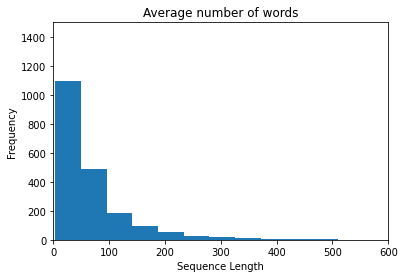

In [9]:
plt.hist(reviews_len, bins=50)
plt.axis([0, 600, 0, 1500])
plt.ylabel('Frequency')
plt.xlabel('Sequence Length');
plt.title("Average number of words");

Our next function `fix_review_len()` will do a useful job, this function is designed to fix the size of reviews to a fixed size to feed them into a neural network with reviews of a certain length. Reviews whose length is less than fixed will be extended by zeros. This process does not affect the algorithm and reviews longer than the specified length will be truncated.

In [10]:
def fix_review_len(review, length):
    if len(review) > length:
        review = review[:length]
    elif len(review) < length:
        for i in range(length - len(review)):
            zeros = [0] * 300
            review.append(zeros)
    return review

example = [3, 1, 2, 4, 5]
example = fix_review_len(example, 7)
print(example) 

[3, 1, 2, 4, 5, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Now let's slightly improve our `sent_embed()` function from previous part and then update our dataset with word vectors.

Based on the histogram data, as well as the average number of words in the files, we can say with confidence that most reviews will have less than 100 words, which is the maximum value of the length of the sequence that we set.

In [11]:
def sent_embed(words, docs):
    x_sent_embed, y_sent_embed = [], [] 
    
    max_seq_len = 100
    
    # recover the embedding of each sentence with the average of the vector that composes it
    # sent - sentence, state - state of the sentence (pos/neg)
    for sent, state in docs:
        # average embedding of all words in a sentence
        sent_embed = []
        for word in sent:
            try:
                # if word is present in the dictionary - add its vector representation
                sent_embed.append(model[word])
            except KeyError:
                # if word is not in the dictionary - add a zero vector
                sent_embed.append([0] * 300)
        
        # add a sentence vector to the list
        sent_embed = fix_review_len(sent_embed, max_seq_len)
        x_sent_embed.append(sent_embed)
        
        # add a label to y_sent_embed
        if state == 'pos': y_sent_embed.append(1)
        elif state == 'neg': y_sent_embed.append(0)
            
    return x_sent_embed, y_sent_embed

In [12]:
x, y = sent_embed(words, docs)

In [13]:
x = np.array(x)
print("Shape of X:", x.shape)

Shape of X: (1997, 100, 300)


<h3 align="center">Split Corpus</h3>

Now, for further work, we will divide our corpus for training, testing and development sets:

In [14]:
from sklearn.model_selection import train_test_split

# train test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# train dev
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [15]:
print('Length of x_train:', len(x_train), '| Length of y_train:', len(y_train))
print('Length of x_test:  ', len(x_test), '| Length of y_test: ', len(y_test))
print('Length of x_val:   ', len(x_val), '| Length of y_val:  ', len(y_val))

Length of x_train: 1277 | Length of y_train: 1277
Length of x_test:   400 | Length of y_test:  400
Length of x_val:    320 | Length of y_val:   320


In [16]:
print("Shape of x_train set:", x_train.shape)

Shape of x_train set: (1277, 100, 300)


<h2 align="center">LSTM Model (Batch Size)</h2>

Keras's benefit is that it is built on top of symbolic mathematical libraries such as TensorFlow and Theano for fast and efficient computation. This is needed with large neural networks.

A downside of using these efficient libraries is that you must define the scope of your data upfront and for all time. Specifically, the batch size.

The batch size limits the number of samples to be shown to the network before a weight update can be performed. This same limitation is then imposed when making predictions with the fit model.

Specifically, the batch size used when fitting your model controls how many predictions you must make at a time.

This is often not a problem when you want to make the same number predictions at a time as the batch size used during training.

This does become a problem when you wish to make fewer predictions than the batch size. For example, you may get the best results with a large batch size but are required to make predictions for one observation at a time on something like a time series or sequence problem.

This is why it may be desirable to have a different batch size when fitting the network to training data than when making predictions on test data or new input data.

<h3 align="center">Setting Up and Creating the Network</h3>

The network has one input, a hidden layer with 100 units, and an output layer with 1 unit. The default tanh activation functions are used in the LSTM units and a linear activation function in the output layer.

A mean squared error optimization function is used for this regression problem with the efficient ADAM optimization algorithm.

So now let's configure and create the network:

In [17]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense
from keras.optimizers import Adam

# configure network
n_neurons = 100
n_epoch = 15

# design network
model_batch = Sequential()
model_batch.add(LSTM(n_neurons, input_shape=(x.shape[1], x.shape[2])))
model_batch.add(Dense(1, activation='sigmoid'))
model_batch.compile(loss='mean_squared_error', optimizer='adam', metrics=['binary_accuracy'])

print(model_batch.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 160,501
Trainable params: 160,501
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
hist = model_batch.fit(x_train, np.asarray(y_train), epochs=n_epoch)

Epoch 1/15
40/40 [==============================] - 9s 114ms/step - loss: 0.2542 - binary_accuracy: 0.4929
Epoch 2/15
40/40 [==============================] - 5s 113ms/step - loss: 0.2219 - binary_accuracy: 0.5956
Epoch 3/15
40/40 [==============================] - 5s 133ms/step - loss: 0.2045 - binary_accuracy: 0.6350
Epoch 4/15
40/40 [==============================] - 5s 116ms/step - loss: 0.1855 - binary_accuracy: 0.6753
Epoch 5/15
40/40 [==============================] - 4s 108ms/step - loss: 0.1521 - binary_accuracy: 0.8104
Epoch 6/15
40/40 [==============================] - 4s 101ms/step - loss: 0.1788 - binary_accuracy: 0.7620
Epoch 7/15
40/40 [==============================] - 4s 108ms/step - loss: 0.1709 - binary_accuracy: 0.7565
Epoch 8/15
40/40 [==============================] - 4s 102ms/step - loss: 0.1698 - binary_accuracy: 0.7771
Epoch 9/15
40/40 [==============================] - 4s 98ms/step - loss: 0.1614 - binary_accuracy: 0.7606
Epoch 10/15
40/40 [===================

In [19]:
score_batch = model_batch.evaluate(x_val, np.asarray(y_val))
print("\nModel loss:", str(round(score_batch[0] * 100, 2)) + '%', 
      "\nModel Accuracy:",str(round(score_batch[1] * 100, 2)) + '%')

10/10 [==============================] - 1s 36ms/step - loss: 0.2327 - binary_accuracy: 0.6531

Model loss: 23.27% 
Model Accuracy: 65.31%


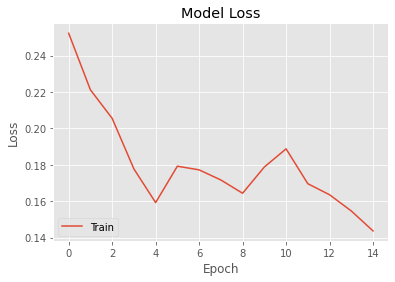

In [20]:
plt.style.use('ggplot')
plt.plot(hist.history['loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower left')

plt.show()

The results are not entirely satisfactory, but let's save this model and try a different approach.

In [21]:
from keras.models import load_model

model_batch.save('LSTM-Batch-Model.h5')  # save model
del model_batch  # delete existing model

# returns a compiled model, identical to the previous one
model_batch = load_model('LSTM-Batch-Model.h5')

Let's check if everything is correct:

In [22]:
model_batch.evaluate(x_val, np.asarray(y_val))

10/10 [==============================] - 2s 35ms/step - loss: 0.2327 - binary_accuracy: 0.6531


[0.23269912600517273, 0.653124988079071]